## Урок 3. Выбор и обучение модели на отобранных признаках. Сравнение качества и оценка модели

На одном из первых этапов решения любой задачи машинного обучения требуется собрать данные, которые позволят предсказывать целевую переменную. Перечень этих данных определяется, во-первых, технической воможностью сбора конкретных данных, а во-вторых, интуитивно понятной причинно-следственной связью. Исходя из собранных данных на этапе __data-mining__'а, производится далее формирование признакового пространства - __feature engineering__. Разумеется, не все полученные признаки будут в равной степени иметь предсказательную значимость: какие-то из признаков могут никак не улучшать обобщающую способность модели машинного обучения, а какие-то могут и вовсе вносить помехи в работу модели и ухудшать результат.

Процесс отбора признаков называется __feature selection__. Цель данного процесса - оставить в датасете только значимые признаки, уменьшить признаковое пространство. Отбор признаков позволяет, зачастую, улучшить качество модели, при этом уменьшит время обучения.

## Выбор модели

Задача бинарной классификации для вас хорошо уже знакома, поэтому подробно останавливаться на том, какие модели позволяют решить эту задача, не будем. Напомним лишь, что мы можем использовать для этой задачи какие-то простые модели, например, LogisticRegression, DecisionTreeClassifier, KNeighborsClassifier, или же более сложные ансамбли - RandomForestClassifier, XGBClassifier, CatBoostClassifier, LGBMClassifier и т.д. Для некоего базового решения (__baseline__) воспользуемся реализацией XGBoost из sklearn с фиксированными параметрами модели.

Также напишем пару вспомогательных функций для оценки качества и отрисовки графиков.

In [78]:
import pandas as pd
import numpy as np
import xgboost as xgb
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from scipy import interp
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import chi2, mutual_info_classif, RFECV
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, \
                            log_loss, roc_auc_score, average_precision_score, confusion_matrix

def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 
    return precision, recall, f1, ll, roc_auc

def xgb_fit_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=3,
                            n_estimators=100,
                            learning_rate=0.1,
                            nthread=5,
                            subsample=1.,
                            colsample_bytree=0.5,
                            min_child_weight = 3,
                            reg_alpha=0.,
                            reg_lambda=0.,
                            seed=42,
                            missing=1e10)

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    predict_proba_test = clf.predict_proba(X_test)
    predict_test = clf.predict(X_test)
    precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
        evaluation(y_test, predict_test, predict_proba_test[:, 1])
    return clf

def plot_importance(importance, features, name):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [11]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, ratio=0.3).fit_sample(X_train, y_train)

CPU times: user 11.7 s, sys: 1.24 s, total: 13 s
Wall time: 12.1 s


## Методы отбора признаков

Существуют различные способы отбора признаков. Рассмотрим некоторые из существующих подходов.

### Feature Importance, как атрибут модели

Некоторые модели, такие как XGBoost, LGBMClassifier, RandomForestRegressor и др., имеют атрибут __feature\_importances\___, который показывает, насколько важен каждый из признаков. Эта "важность" может расчитываться как, например, путем суммирования прироста качества при разбиении узлов дерева по этому признаку, или же равняться количеству разбиений в дереве, которые произошли по данному признаку.

Посмотрим на примере XGBoost, как это выглядит.

Precision: 0.29292604501607716
Recall: 0.43924783027965286
F1: 0.35146604938271603
Log Loss: 0.13287162207657305
ROC AUC: 0.8993346961643733


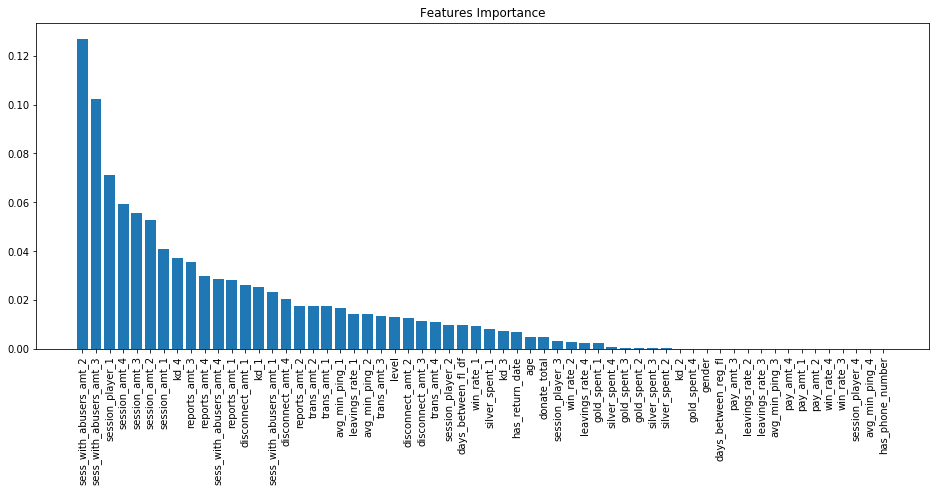

CPU times: user 1min 33s, sys: 702 ms, total: 1min 34s
Wall time: 1min 35s


In [12]:
%%time
fitted_clf = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
feature_importance = plot_importance(fitted_clf.feature_importances_, X.columns, 'Features Importance')

Попробуем обучить модель на Топ-30 признаках и оценить качество.

In [13]:
# Попробовать отобрать 35 признаков
X_train_FI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_FI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_FI, y_train_balanced, X_test_FI, y_test)

print('Признаков было:', X_train.shape[1])
print('Признаков стало:', X_train_FI.shape[1])

Precision: 0.29053095950842917
Recall: 0.4445515911282546
F1: 0.35140543115769407
Log Loss: 0.13318901507789604
ROC AUC: 0.8982947672289734
Признаков было: 60
Признаков стало: 30


Видим, что кол-во признаков уменьшили __вдвое__, а качество практически не изменилось.

### Хи-квадрат

Данный способ позволяет отбирать признаки, используя статистический тест о зависимости между признаком и целевой переменной. Тест Хи-квадрат применяется в статистике для проверки независиости двух событий. Чем больше значение статистики Хи-квадрат, тем больше сильна завиимости между признаком и таргетом. Рассчитаем статистику и отберем признаки.

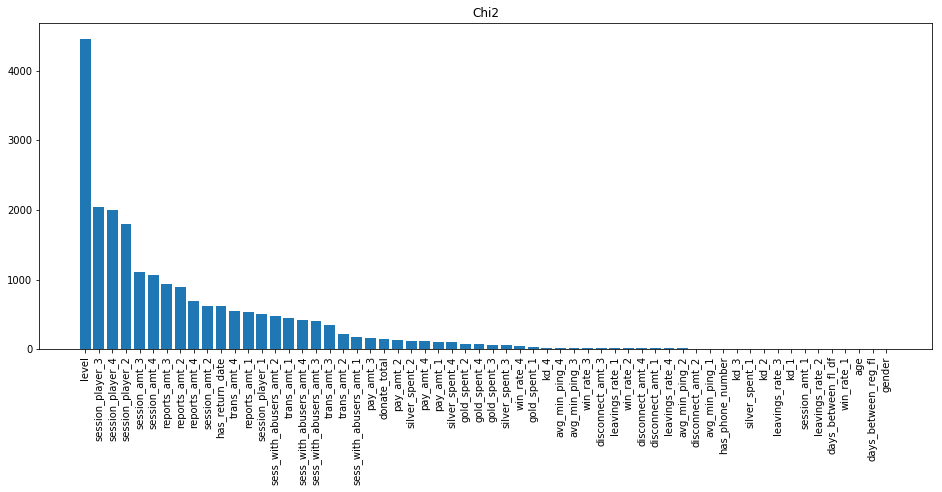

CPU times: user 823 ms, sys: 83.9 ms, total: 907 ms
Wall time: 682 ms


In [14]:
%%time
# Обратитевнимание, что значения в датасете должны быть неотрицательными для расчета Хи квартат
chi2_test = chi2(X_train_balanced, y_train_balanced)
feature_importance = plot_importance(chi2_test[0], X.columns, 'Chi2')

Попробуем обучить модель на Топ-30 признаков и оценить качество.

In [15]:
X_train_CHI = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_CHI = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

fitted_clf = xgb_fit_predict(X_train_CHI, y_train_balanced, X_test_CHI, y_test)

# Со

Precision: 0.2786937730110453
Recall: 0.4197203471552555
F1: 0.33496873496873497
Log Loss: 0.14925395211658643
ROC AUC: 0.8237022223877686


In [44]:
fitted_clf()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=10000000000.0, n_estimators=100,
              n_jobs=1, nthread=5, objective='binary:logistic', random_state=0,
              reg_alpha=0.0, reg_lambda=0.0, scale_pos_weight=1, seed=42,
              silent=None, subsample=1.0, verbosity=1)

Видим, что на отобранных Хи-квадратом признаках качество упало сильнее, чем при отборе Feature Impotrance модели, но в целом так же незначительно.

### Взаимная информация

Отбор признаков на основании значения [взаимной информации](https://ru.wikipedia.org/wiki/%D0%92%D0%B7%D0%B0%D0%B8%D0%BC%D0%BD%D0%B0%D1%8F_%D0%B8%D0%BD%D1%84%D0%BE%D1%80%D0%BC%D0%B0%D1%86%D0%B8%D1%8F).

In [16]:
%%time
mi = mutual_info_classif(X_train_balanced, y_train_balanced)

CPU times: user 4h 22min 10s, sys: 4min 38s, total: 4h 26min 49s
Wall time: 4h 40min 41s


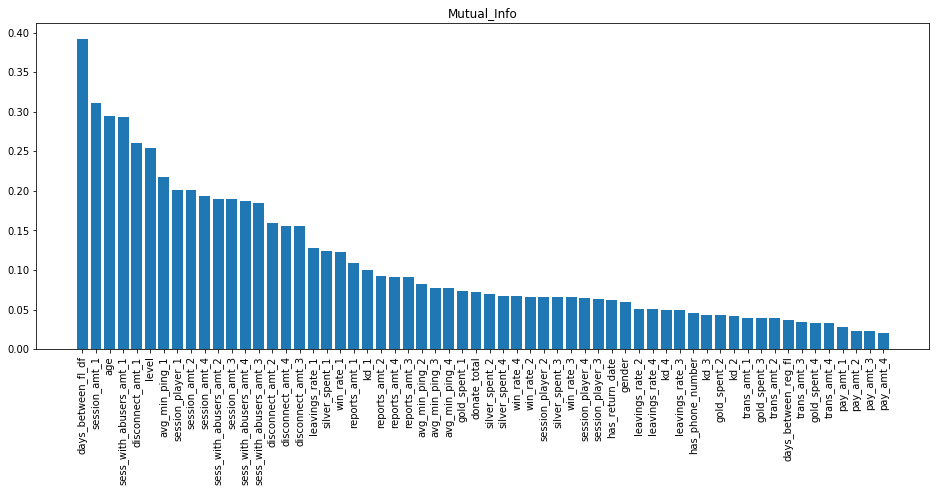

In [39]:
feature_importance = plot_importance(mi, X.columns, 'Mutual_Info')

In [38]:
import pickle
obj = mi
output = open('mutual_info_classif.pkl', 'wb')
pickle.dump(obj, output, 2)
output.close()

Для данного подхода и следующих в качестве __домашнего задания__ предлагается выбрать N лучших признаков по рассчитанной метрике и посмотреть качество предсказания на них.

### RFE (Recursive Feature Elimination)

Рекурскивный отсев признаков - убираем на каждой итерации самые слабые признаки и делаем это до тех пор, пока не увидим заметного снижения качества. На каком кол-ве признаков остановимся, то и считаем оптимальным.

In [120]:
%%time
STEP = 5
logit = LogisticRegression(random_state=42)

selector = RFECV(estimator=logit, step=STEP, cv=StratifiedKFold(2), scoring='f1')
selector.fit(X_train_balanced, y_train_balanced)

good_features = X.columns[selector.support_]
print("Optimal number of features : %d" % selector.n_features_)

Optimal number of features : 45
CPU times: user 1min 21s, sys: 2.99 s, total: 1min 24s
Wall time: 1min 21s


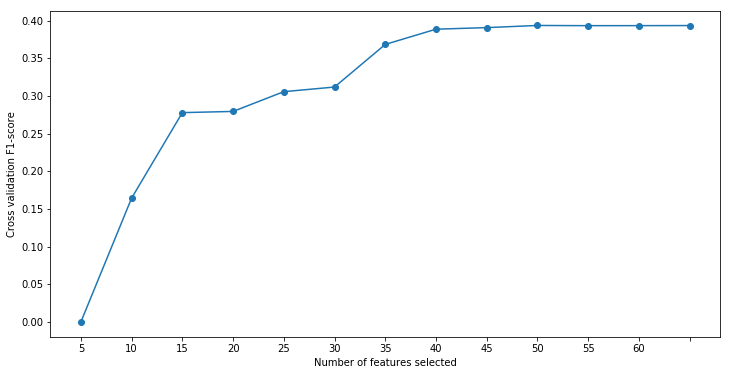

In [121]:
plt.figure(figsize=(12,6))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, 'o-')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation F1-score")
plt.xticks(range(1, len(selector.grid_scores_) + 1), reversed(list(range(X_train.shape[1], 1, -STEP))))
plt.show()

In [122]:
good_features

Index(['level', 'donate_total', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3',
       'trans_amt_4', 'pay_amt_1', 'pay_amt_2', 'pay_amt_4', 'reports_amt_1',
       'reports_amt_2', 'reports_amt_4', 'sess_with_abusers_amt_1',
       'sess_with_abusers_amt_2', 'sess_with_abusers_amt_3',
       'sess_with_abusers_amt_4', 'disconnect_amt_1', 'disconnect_amt_2',
       'disconnect_amt_3', 'disconnect_amt_4', 'session_amt_1',
       'session_amt_2', 'session_amt_3', 'session_amt_4', 'avg_min_ping_1',
       'avg_min_ping_3', 'avg_min_ping_4', 'session_player_1',
       'session_player_2', 'session_player_3', 'win_rate_1', 'win_rate_2',
       'win_rate_3', 'win_rate_4', 'kd_1', 'kd_3', 'kd_4', 'leavings_rate_1',
       'leavings_rate_4', 'gold_spent_1', 'silver_spent_1', 'silver_spent_2',
       'silver_spent_3', 'age', 'has_return_date'],
      dtype='object')

In [123]:
len(good_features)

45

### Permutation Importance (PI)

Перемешивание значений столбца важного признака приводит к заметному снижению качества работы модели

In [41]:
# Модуль можно установить, сделав
# !pip install eli5
# А можно использовать локальный модуль
from ELI5 import PermutationImportance

In [95]:
X_train = pd.DataFrame(X_train_balanced, columns=X.columns) #[feature_importance[0][:30]]
X_test = pd.DataFrame(X_test, columns=X.columns) #[feature_importance[0][:30]]

In [103]:
type(dataset['is_churned'])

pandas.core.series.Series

In [105]:
y_train = pd.DataFrame({'is_churned': y})
y_train.describe()

,is_churned
count,469475.000000
mean,0.029448
std,0.169058
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [114]:
# Ошибка feature_names mismatch. В array X_ и y_train_balanced нет заголовков колонок. Как лечить?

# %%time
perm = PermutationImportance(fitted_clf, random_state=42).fit(X_train, y_train)

res = pd.DataFrame(X.columns, columns=['feature'])
res['score'] = perm.feature_importances_
res['std'] = perm.feature_importances_std_
res = res.sort_values(by='score', ascending=False).reset_index(drop=True)

ValueError: feature_names mismatch: ['level', 'session_player_3', 'session_player_4', 'session_player_2', 'session_amt_3', 'session_amt_4', 'reports_amt_3', 'reports_amt_2', 'reports_amt_4', 'session_amt_2', 'has_return_date', 'trans_amt_4', 'reports_amt_1', 'session_player_1', 'sess_with_abusers_amt_2', 'trans_amt_1', 'sess_with_abusers_amt_4', 'sess_with_abusers_amt_3', 'trans_amt_3', 'trans_amt_2', 'sess_with_abusers_amt_1', 'pay_amt_3', 'donate_total', 'pay_amt_2', 'silver_spent_2', 'pay_amt_4', 'pay_amt_1', 'silver_spent_4', 'gold_spent_2', 'gold_spent_4'] ['level', 'donate_total', 'trans_amt_1', 'trans_amt_2', 'trans_amt_3', 'trans_amt_4', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'reports_amt_1', 'reports_amt_2', 'reports_amt_3', 'reports_amt_4', 'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2', 'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4', 'disconnect_amt_1', 'disconnect_amt_2', 'disconnect_amt_3', 'disconnect_amt_4', 'session_amt_1', 'session_amt_2', 'session_amt_3', 'session_amt_4', 'avg_min_ping_1', 'avg_min_ping_2', 'avg_min_ping_3', 'avg_min_ping_4', 'session_player_1', 'session_player_2', 'session_player_3', 'session_player_4', 'win_rate_1', 'win_rate_2', 'win_rate_3', 'win_rate_4', 'kd_1', 'kd_2', 'kd_3', 'kd_4', 'leavings_rate_1', 'leavings_rate_2', 'leavings_rate_3', 'leavings_rate_4', 'gold_spent_1', 'gold_spent_2', 'gold_spent_3', 'gold_spent_4', 'silver_spent_1', 'silver_spent_2', 'silver_spent_3', 'silver_spent_4', 'age', 'gender', 'days_between_reg_fl', 'days_between_fl_df', 'has_return_date', 'has_phone_number']
training data did not have the following fields: avg_min_ping_1, kd_3, disconnect_amt_1, win_rate_4, gender, disconnect_amt_4, days_between_fl_df, session_amt_1, gold_spent_1, win_rate_1, kd_2, gold_spent_3, avg_min_ping_2, disconnect_amt_2, leavings_rate_4, kd_4, leavings_rate_2, has_phone_number, silver_spent_1, avg_min_ping_4, kd_1, win_rate_2, win_rate_3, leavings_rate_3, leavings_rate_1, age, days_between_reg_fl, silver_spent_3, avg_min_ping_3, disconnect_amt_3

In [107]:
plt.figure(figsize=(16,6))
plt.bar(range(res.shape[0]), res['score'], yerr=res['std'], align='center')
plt.xticks(range(res.shape[0]), res['feature'], rotation=90)
plt.title('Permutation Importance')
plt.tight_layout()
plt.ylim(-0.001,0.012)
plt.show()

KeyError: 'score'

<Figure size 1152x432 with 0 Axes>

In [76]:
good_features = res.loc[res['score'] > 0]['feature']
print('Кол-во отобранных признаков:', good_features.shape[0])

KeyError: 'score'

In [77]:
good_features

Index(['trans_amt_1', 'trans_amt_2', 'trans_amt_3', 'reports_amt_1',
       'reports_amt_2', 'reports_amt_3', 'reports_amt_4',
       'sess_with_abusers_amt_1', 'sess_with_abusers_amt_2',
       'sess_with_abusers_amt_3', 'sess_with_abusers_amt_4',
       'disconnect_amt_1', 'disconnect_amt_3', 'disconnect_amt_4',
       'session_amt_1', 'session_amt_2', 'session_amt_3', 'session_amt_4',
       'session_player_1', 'leavings_rate_1'],
      dtype='object')

### WoE (Weight of Evidence) and IV (Information Value)

Простое, но в то же время мощное преобразование данных, позволяющее установить монотонную связь между признаками и целевой переменной, а IV может использоваться как мера важности признаков. Преобразование осуществляет корректную обработку как пропущенных значений, так и выбросов, поэтому предварительно обрабатывать датасет не нужно для WOE.

In [54]:
# Для простоты расчетов используем локальный модуль
from WOE_IV import data_vars

dataset_raw = pd.read_csv('dataset/dataset_raw_train.csv', sep=';')
X_raw = dataset_raw.drop(['user_id', 'is_churned'], axis=1)
y_raw = dataset_raw['is_churned']

In [55]:
%%time
# Рассчитаем IV
iv_df, iv = data_vars(X_raw, y_raw)

CPU times: user 1min 4s, sys: 1.53 s, total: 1min 6s
Wall time: 36.2 s


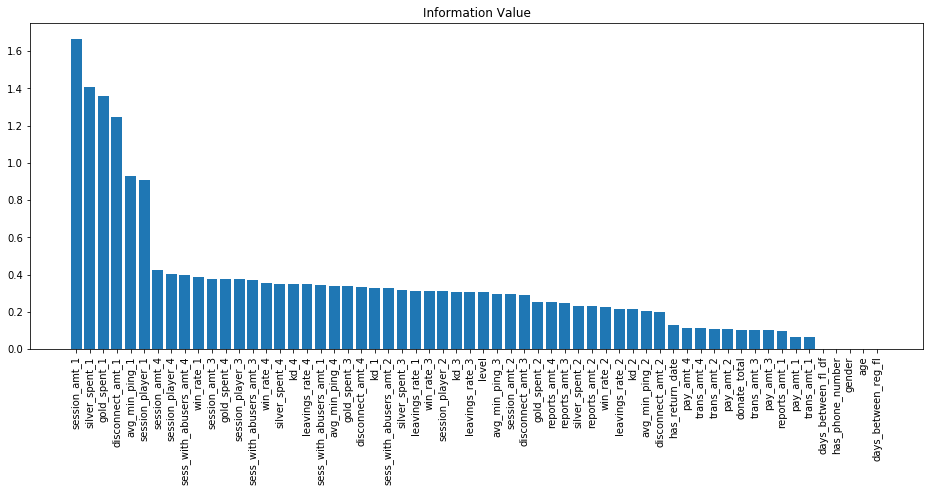

In [56]:
IV = iv.sort_values('IV', ascending=False)
plt.figure(figsize=(16,6))
plt.bar(range(IV.shape[0]), IV['IV'], align='center')
plt.xticks(range(IV.shape[0]), IV['VAR_NAME'].values, rotation=90)
plt.title('Information Value')
plt.show()

In [57]:
%%time
X_WOE = X_raw.copy()

for var in X_WOE.columns:
    small_df = iv_df.loc[iv_df['VAR_NAME'] == var]
    if type(small_df.loc[~small_df['MIN_VALUE'].isnull()]['MIN_VALUE'].values[0]) == str:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 'NaN'
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 'NaN'
    else:
        small_df.loc[small_df['MIN_VALUE'].isnull(), 'MIN_VALUE'] = 0.
        small_df.loc[small_df['MAX_VALUE'].isnull(), 'MAX_VALUE'] = 0.
    transform_dict = dict(zip(small_df['MAX_VALUE'], small_df['WOE']))
    replace_cmd = ''
    replace_cmd1 = ''
    for i in sorted(transform_dict.items()):
        replace_cmd += str(i[1]) + ' if x <= ' + str(i[0]) + ' else '
        replace_cmd1 += str(i[1]) + ' if x == "' + str(i[0]) + '" else '
    replace_cmd += '0'
    replace_cmd1 += '0'
    if replace_cmd != '0':
        try:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd))
        except:
            X_WOE[var] = X_WOE[var].apply(lambda x: eval(replace_cmd1))

CPU times: user 12min 16s, sys: 17.3 s, total: 12min 33s
Wall time: 13min 6s


In [58]:
X_train_WOE, X_test_WOE, y_train_WOE, y_test_WOE = train_test_split(X_WOE, 
                                                                    y_raw, 
                                                                    test_size=0.3,
                                                                    shuffle=True, 
                                                                    stratify=y_raw, 
                                                                    random_state=100)
X_train_WOE_balanced, y_train_WOE_balanced = SMOTE(random_state=42, ratio=0.3).fit_sample(X_train_WOE, y_train_WOE)

In [93]:
# Выделим значимые признаки, для таких признаков IV не должно быть близко ни к 0, ни к 1
significant_features = IV.loc[(IV['IV'] >= 0.2) & (IV['IV'] <= 0.8)]['VAR_NAME']
print('Значимых признаков:', significant_features.nunique())
# significant_features

Значимых признаков: 38


Из-за установления монотонной связи WOE преобразование тесно связано с логистической регрессией и в некотором смысле "подготавливает" датасет для logit'а. Посмотрим, какое качество получается на WOE датасете у логистической регрессии и сравним это с качеством на "обычном".

In [60]:
%%time
logit = LogisticRegression(random_state=42)
logit.fit(X_train_WOE_balanced, y_train_WOE_balanced)

predict_proba_test = logit.predict_proba(X_test_WOE)
predict_test = logit.predict(X_test_WOE)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test_WOE, predict_test, predict_proba_test[:, 1])

Precision: 0.22875520927704293
Recall: 0.6087270973963356
F1: 0.33254313183195044
Log Loss: 0.19276619773707745
ROC AUC: 0.89424346210935
CPU times: user 14.2 s, sys: 300 ms, total: 14.5 s
Wall time: 14.7 s


In [61]:
%%time
logit_2 = LogisticRegression(random_state=42)
logit_2.fit(X_train_balanced, y_train_balanced)

predict_proba_test = logit_2.predict_proba(X_test)
predict_test = logit_2.predict(X_test)
precision_test, recall_test, f1_test, log_loss_test, roc_auc_test = \
    evaluation(y_test, predict_test, predict_proba_test[:, 1])

Precision: 0.20502235982112144
Recall: 0.28736740597878496
F1: 0.23930937562738405
Log Loss: 0.25676334986987853
ROC AUC: 0.7783950310934079
CPU times: user 9.42 s, sys: 251 ms, total: 9.67 s
Wall time: 9.61 s


Как видим, WOE преобразованный датасет позволяет получить на дефолтном logit'е практически такое же качество, как XGBoost! При этом, для сравнения, тот же logit на обычном датасете показывает заметно худшее качество.

## Оценка качества модели

В качестве базового решения у нас модель XGBoost, которую мы обучили в начале урока. Проведем ее более комплексную оценку, для этого напишем несколько вспомогательных фукнций для более наглядной визуализации результатов.

In [62]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues):
    TN, FP, FN, TP = confusion_matrix(y_true, y_pred).ravel()
    cm = np.array([[TP, FP],
                   [FN, TN]])
    cm_normalized = cm.astype('float') / cm.sum(axis=0)
    # Plot both matrixes - basic and normalized
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
    for ax, normalize, data, title in zip(ax,
                                          [False, True], 
                                          [cm, cm_normalized], 
                                          ['Confusion matrix (without normalization)', 
                                           'Сonfusion matrix (normalized)']):
        im = ax.imshow(data, interpolation='nearest', cmap=cmap)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.1)
        fig.colorbar(im, cax=cax)
        ax.set(xticks=np.arange(data.shape[1]),
               yticks=np.arange(data.shape[0]),
               xticklabels=classes, 
               yticklabels=classes,
               title=title,
               ylabel='Predicted label',
               xlabel='True label')
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')        
        # Loop over data dimensions and create text annotations
        fmt = '.2f' if normalize else 'd'
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                ax.text(j, i, format(data[i, j], fmt), ha="center", va="center", 
                        color="white" if data[i, j] > data.max() / 2. else "black")                
    fig.tight_layout()
    return fig 

def plot_PR_curve(y_true, y_pred, y_prob):
    AP = average_precision_score(y_true=y_true, y_score=y_prob)
    precisions, recalls, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_prob)
    
    plt.step(recalls, precisions, color='b', alpha=0.2, where='post')
    plt.fill_between(recalls, precisions, alpha=0.2, color='b', step='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve: AP={0:0.2f}'.format(AP))
    
def plot_ROC_curve(classifier, X, y, n_folds):
    
    cv = StratifiedKFold(n_splits=n_folds)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    i = 0
    
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1
        
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b', label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % \
             (mean_auc, std_auc), lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

Precision: 0.29292604501607716
Recall: 0.43924783027965286
F1: 0.35146604938271603
Log Loss: 0.13287162207657305
ROC AUC: 0.8993346961643733


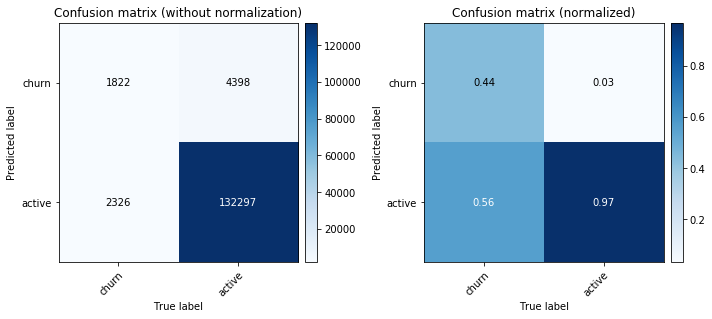

In [63]:
model = xgb_fit_predict(X_train_balanced, y_train_balanced, X_test, y_test)
predict_test = model.predict(X_test)
predict_test_probas = model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()

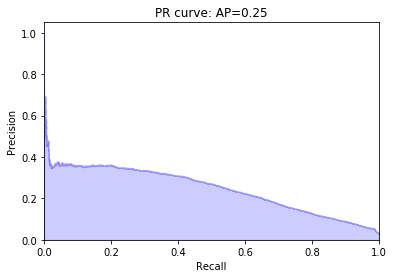

In [64]:
plot_PR_curve(y_test.values, predict_test, predict_test_probas)
plt.show()

In [158]:
%%time
plot_ROC_curve(classifier=model, 
               X=X_test, 
               y=y_test.values, 
               n_folds=3)

KeyError: "None of [Int64Index([ 46928,  46929,  46930,  46931,  46932,  46933,  46934,  46935,\n             46936,  46937,\n            ...\n            140833, 140834, 140835, 140836, 140837, 140838, 140839, 140840,\n            140841, 140842],\n           dtype='int64', length=93895)] are in the [columns]"

In [70]:
# Итоговую модель можно сохранить в файл

with open('baseline_xgb.pcl', 'wb') as f:
    pickle.dump(model, f)

### Литература


1. [XGBoost Docs](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
2. [sklearn.feature_selection ](https://scikit-learn.org/stable/modules/feature_selection.html)
3. [Feature Selection with sklearn and Pandas](https://towardsdatascience.com/feature-selection-with-pandas-e3690ad8504b)
4. [Weight of evidence and Information Value using Python](https://medium.com/@sundarstyles89/weight-of-evidence-and-information-value-using-python-6f05072e83eb)
5. [Weight of Evidence(WOE) and Information Value(IV)](https://www.kaggle.com/pavansanagapati/weight-of-evidence-woe-information-value-iv)

### Д/З

1. Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?
2. Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.
3. Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.
4. __(*)__ Как думаете, можно ли производить отбор признаков с помощью IV, а затем обучать модель случайного леса на отфильтрованном датасете? Ответ обоснуйте. 

In [71]:
import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

Используя признаки, отобранные взаимной информацией, RFE и PI, посмотрите качество XGBoost'а по аналогии с тем, как это делалось на уроке. При каком подходе к отбору признаков получается лучшее значение F1?

In [115]:
len(good_features)


45

In [124]:
%%time
dataset = pd.read_csv('dataset/dataset_train.csv', sep=';')
X = dataset.drop(['user_id', 'is_churned'], axis=1)
y = dataset['is_churned']

X_mm = MinMaxScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_mm, 
                                                    y, 
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    stratify=y, 
                                                    random_state=100)

# Снизим дизбаланс классов
X_train_balanced, y_train_balanced = SMOTE(random_state=42, ratio=0.3).fit_sample(X_train, y_train)

CPU times: user 10.3 s, sys: 1.35 s, total: 11.7 s
Wall time: 10.8 s


In [131]:
X_train_balanced_30 = pd.DataFrame(X_train_balanced, columns=X.columns)[feature_importance[0][:30]]
X_test_30 = pd.DataFrame(X_test, columns=X.columns)[feature_importance[0][:30]]

In [154]:
y_test = pd.DataFrame({'is_churned':y_test})

In [167]:
y_train_balanced  = pd.DataFrame({'is_churned':y_train_balanced})
y_train_balanced

,is_churned
0,0
1,0
2,0
3,0
4,0
...,...
414636,1
414637,1
414638,1
414639,1


In [168]:
y_train = pd.DataFrame({'is_churned':y_train})
y_train

,is_churned
355477,0
36098,0
377729,0
24002,0
179365,0
...,...
344488,0
18437,0
238494,1
414369,0


Precision: 0.29041049225004256
Recall: 0.41104146576663453
F1: 0.3403533286755165
Log Loss: 0.13460104623756838
ROC AUC: 0.8962568300720026


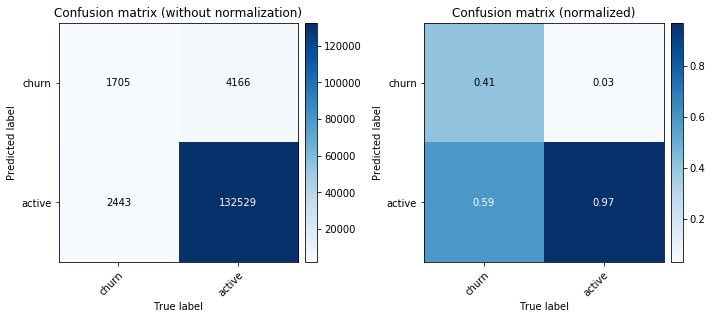

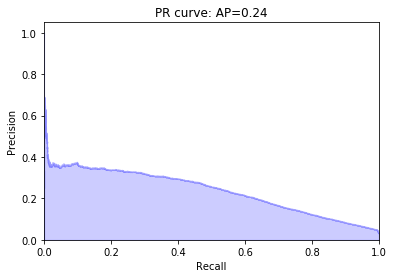

CPU times: user 57.5 s, sys: 589 ms, total: 58.1 s
Wall time: 57.6 s


In [135]:
%%time
model = xgb_fit_predict(X_train_balanced_30, y_train_balanced, X_test_30, y_test)
predict_test = model.predict(X_test)
predict_test_probas = model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()

plot_PR_curve(y_test.values, predict_test, predict_test_probas)
plt.show()




In [169]:
plot_ROC_curve(classifier=model, 
               X=X_test_30, 
               y=y_test.values, n_folds=3)

KeyError: "None of [Int64Index([ 46928,  46929,  46930,  46931,  46932,  46933,  46934,  46935,\n             46936,  46937,\n            ...\n            140833, 140834, 140835, 140836, 140837, 140838, 140839, 140840,\n            140841, 140842],\n           dtype='int64', length=93895)] are in the [columns]"

Обучите любые две другие модели для предсказания оттока для любом из отобранных множеств признаков и сравните качество с уже полученными.

In [177]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.model_selection import GridSearchCV, ShuffleSplit


def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [193]:
param_grid = {'max_depth' : [None, 10,20],
              'max_features' : ['auto',None],
              'n_estimators' :[100,200,300]}

In [197]:
%%time
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier
estimator = SVR()

#create cross validation iterator
cv = ShuffleSplit(test_size=0.3, random_state=42)
# sklearn.model_selection.ShuffleSplit(n_splits=10, test_size=None, train_size=None, random_state=None)
#set up tuning algorithm
clf = RandomForestClassifier(n_estimators =10)
regressor = GridSearchCV(clf, cv=cv, param_grid=param_grid)

#fit the classifier
regressor.fit(X_train_balanced, y_train_balanced)


# Считал всю ночь, пришлось прервать.

KeyboardInterrupt: 

In [ ]:
# test_prediction = regressor.predict(test_features)
# test_accuracy = regressor.score(test_features, test_labels)

%%time
model = regressor(X_train_balanced_30, y_train_balanced, X_test_30, y_test)
predict_test = model.predict(X_test)
predict_test_probas = model.predict_proba(X_test)[:, 1]

plot_confusion_matrix(y_test.values, predict_test, classes=['churn', 'active'])
plt.show()

plot_PR_curve(y_test.values, predict_test, predict_test_probas)
plt.show()



In [ ]:
plot_ROC_curve(classifier=model, 
               X=X_test_30, 
               y=y_test.values, n_folds=3)

In [ ]:
# # Приведение типов для модели CatBoost
# for colname in CAT_FEATURE_NAMES:
#     df_train[colname] = pd.Categorical(df_train[colname])
    
# df_train[CAT_FEATURE_NAMES].dtypes

In [ ]:
# # CatBoost
# model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
# model_catb.fit(X_train, y_train)

# y_train_pred = model_catb.predict(X_train)
# y_test_pred = model_catb.predict(X_test)

# get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Постройте матрицу корреляций и предложите отбор признаков на основании этой матрицы.

In [199]:
BASE_FEATURE_NAMES = X_train_balanced_30.columns.tolist()
TARGET_NAME = y_train_balanced.columns.tolist()

print(BASE_FEATURE_NAMES)
print(TARGET_NAME)

dataset['is_churned'] = y_train_balanced['is_churned']

['days_between_fl_df', 'session_amt_1', 'age', 'sess_with_abusers_amt_1', 'disconnect_amt_1', 'level', 'avg_min_ping_1', 'session_player_1', 'session_amt_2', 'session_amt_4', 'sess_with_abusers_amt_2', 'session_amt_3', 'sess_with_abusers_amt_4', 'sess_with_abusers_amt_3', 'disconnect_amt_2', 'disconnect_amt_4', 'disconnect_amt_3', 'leavings_rate_1', 'silver_spent_1', 'win_rate_1', 'reports_amt_1', 'kd_1', 'reports_amt_2', 'reports_amt_4', 'reports_amt_3', 'avg_min_ping_2', 'avg_min_ping_3', 'avg_min_ping_4', 'gold_spent_1', 'donate_total']
['is_churned']


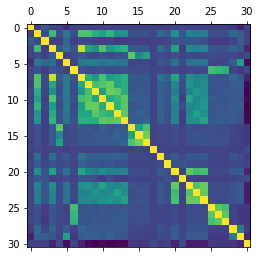

,days_between_fl_df,session_amt_1,age,sess_with_abusers_amt_1,disconnect_amt_1,level,avg_min_ping_1,session_player_1,session_amt_2,session_amt_4,sess_with_abusers_amt_2,session_amt_3,sess_with_abusers_amt_4,sess_with_abusers_amt_3,disconnect_amt_2,disconnect_amt_4,disconnect_amt_3,leavings_rate_1,silver_spent_1,win_rate_1,reports_amt_1,kd_1,reports_amt_2,reports_amt_4,reports_amt_3,avg_min_ping_2,avg_min_ping_3,avg_min_ping_4,gold_spent_1,donate_total,is_churned
days_between_fl_df,1,-0.0102072,0.101957,-0.00328665,0.0034328,-0.0884358,0.00793579,0.00347749,-0.00787108,-0.00499238,-0.00485404,-0.00481495,-0.00435618,-0.00253462,0.00216708,0.00234781,0.000508801,0.00134309,-0.00948754,-0.000889679,-0.000145898,0.0233436,-0.00104207,0.000531315,0.000224912,0.00524891,0.00995586,0.00724352,-0.0317911,-0.136705,0.00130454
session_amt_1,-0.0102072,1,0.033629,0.602459,0.0569437,0.250164,0.0687939,0.651861,0.647776,0.532724,0.471609,0.572236,0.387799,0.41689,0.0660127,0.0603438,0.0643028,0.0263979,0.203255,0.128735,0.379594,0.0887993,0.323209,0.271619,0.29176,0.0572618,0.0514152,0.0495538,0.176301,0.137207,-0.0109652
age,0.101957,0.033629,1,-0.00806702,-0.00945683,0.178227,-0.0242202,0.033688,0.0215254,0.00830739,-0.0125476,0.0137996,-0.0262165,-0.0178505,-0.0123224,-0.0155192,-0.0165609,-0.000977301,-0.0118388,0.0165617,0.0813917,0.0729974,0.0783225,0.0709686,0.0752718,-0.0278743,-0.0282438,-0.031993,0.00911765,0.117169,0.00156134
sess_with_abusers_amt_1,-0.00328665,0.602459,-0.00806702,1,0.110543,0.216397,0.0859332,0.905611,0.492284,0.396184,0.666539,0.430907,0.52304,0.573325,0.100767,0.0882043,0.09652,0.000773876,0.206817,0.0769685,0.483558,-0.0249803,0.375059,0.302782,0.328153,0.0884369,0.0798064,0.0760169,0.154168,0.0857367,-0.128551
disconnect_amt_1,0.0034328,0.0569437,-0.00945683,0.110543,1,-0.00253857,0.0481943,0.117081,0.0473857,0.0348184,0.0721844,0.0380386,0.0712325,0.0799132,0.689243,0.33714,0.473226,0.017877,0.026789,0.0181426,0.047894,0.00668172,0.0339078,0.0257768,0.027075,0.0374083,0.0347458,0.0295093,0.0161013,-0.00939481,0.0329203
level,-0.0884358,0.250164,0.178227,0.216397,-0.00253857,1,-0.00230199,0.248878,0.278352,0.276883,0.229241,0.280113,0.228728,0.230823,0.0134206,0.0203339,0.0189959,-0.0140701,0.0929148,0.0579534,0.225861,0.0404626,0.228179,0.226838,0.230859,0.0106388,0.00983231,0.0116338,0.111002,0.468154,-0.208414
avg_min_ping_1,0.00793579,0.0687939,-0.0242202,0.0859332,0.0481943,-0.00230199,1,0.0840177,0.0529978,0.0445234,0.0699274,0.0453614,0.0564421,0.061732,0.0442125,0.0411499,0.0447007,0.0147016,0.0170289,0.0115843,0.0294757,-0.00023558,0.0239693,0.0202122,0.0209038,0.632491,0.585544,0.561691,0.000217553,-0.046422,0.0228672
session_player_1,0.00347749,0.651861,0.033688,0.905611,0.117081,0.248878,0.0840177,1,0.519269,0.41508,0.637048,0.453006,0.49566,0.546863,0.102644,0.0872829,0.0973756,0.0100108,0.227706,0.144291,0.497026,0.088483,0.385034,0.311272,0.33791,0.0849213,0.0756317,0.0726859,0.169052,0.101165,-0.123808
session_amt_2,-0.00787108,0.647776,0.0215254,0.492284,0.0473857,0.278352,0.0529978,0.519269,1,0.630815,0.663629,0.703755,0.48021,0.535922,0.0963095,0.0826515,0.0927535,0.00730743,0.143117,0.0985315,0.337697,0.05812,0.416605,0.320324,0.355203,0.0980199,0.080395,0.0711981,0.119196,0.141049,-0.220875
session_amt_4,-0.00499238,0.532724,0.00830739,0.396184,0.0348184,0.276883,0.0445234,0.41508,0.630815,1,0.462619,0.716481,0.680638,0.534876,0.0670877,0.11538,0.0915406,0.0042565,0.131188,0.083297,0.282516,0.0428989,0.314523,0.413465,0.350026,0.0690482,0.0842277,0.108966,0.103812,0.132385,-0.245726


In [221]:
X_corr = dataset.corr()
plt.matshow(X_corr)
plt.show()
X_corr.style.background_gradient(cmap='coolwarm')

In [225]:
DROP_FEATURES = ['session_player_1', 'disconnect_amt_2', 'session_amt_3', 'session_amt_4', 'sess_with_abusers_amt_4', 'disconnect_amt_4', 'reports_amt_3']

In [228]:
FEATURES = list(set(BASE_FEATURE_NAMES) - set(DROP_FEATURES))

In [229]:
FEATURES

['avg_min_ping_1',
 'disconnect_amt_1',
 'sess_with_abusers_amt_3',
 'days_between_fl_df',
 'session_amt_1',
 'gold_spent_1',
 'win_rate_1',
 'sess_with_abusers_amt_1',
 'avg_min_ping_2',
 'silver_spent_1',
 'avg_min_ping_4',
 'sess_with_abusers_amt_2',
 'kd_1',
 'level',
 'session_amt_2',
 'reports_amt_4',
 'donate_total',
 'leavings_rate_1',
 'age',
 'reports_amt_1',
 'reports_amt_2',
 'avg_min_ping_3',
 'disconnect_amt_3']

In [230]:
X_train_features = X_train_balanced_30[FEATURES]

In [231]:
X_train_features

,avg_min_ping_1,disconnect_amt_1,sess_with_abusers_amt_3,days_between_fl_df,session_amt_1,gold_spent_1,win_rate_1,sess_with_abusers_amt_1,avg_min_ping_2,silver_spent_1,...,level,session_amt_2,reports_amt_4,donate_total,leavings_rate_1,age,reports_amt_1,reports_amt_2,avg_min_ping_3,disconnect_amt_3
0,0.052948,0.000000,0.000000,0.005589,0.000000,0.000000,0.000000,0.000000,0.051007,0.000000,...,0.275000,0.000000,0.000000,0.001340,0.000000,0.232877,0.000000,0.000000,0.047541,0.000000
1,0.052948,0.000000,0.000000,0.463115,0.000000,0.000000,0.000000,0.000000,0.051007,0.000000,...,0.350000,0.000000,0.000000,0.001377,0.000000,0.315068,0.000000,0.000000,0.047541,0.000000
2,0.103973,0.000560,0.022416,0.000373,0.038136,0.000000,0.001236,0.021552,0.103042,0.000716,...,0.300000,0.040870,0.000000,0.003847,0.000000,0.260274,0.000000,0.027778,0.083607,0.000000
3,0.050745,0.001791,0.027219,0.032042,0.035593,0.000332,0.000837,0.037931,0.048415,0.000146,...,0.425000,0.037155,0.104167,0.003994,0.000028,0.232877,0.025926,0.000000,0.030211,0.001695
4,0.018622,0.001120,0.003736,0.008197,0.012712,0.000000,0.000793,0.000000,0.042606,0.000000,...,0.025000,0.022293,0.000000,0.000574,0.000846,0.246575,0.000000,0.000000,0.046516,0.000509
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414636,0.043466,0.000035,0.024511,0.002468,0.025424,0.000000,0.000760,0.000000,0.049316,0.000000,...,0.100000,0.000933,0.000000,0.000989,0.000846,0.367284,0.000000,0.000000,0.048456,0.000794
414637,0.005795,0.000000,0.005014,0.000745,0.042485,0.000000,0.000793,0.000000,0.051007,0.000000,...,0.150000,0.000000,0.000000,0.002899,0.000000,0.205479,0.000000,0.000000,0.005463,0.001689
414638,0.138315,0.001931,0.000000,0.018195,0.003497,0.000000,0.000451,0.020617,0.051007,0.001070,...,0.306877,0.000000,0.000000,0.003022,0.000243,0.308906,0.000000,0.000000,0.047541,0.000000
414639,0.059354,0.001388,0.000000,0.012597,0.019327,0.001132,0.000904,0.005747,0.051007,0.000119,...,0.282014,0.000000,0.000000,0.015102,0.000079,0.191781,0.025926,0.000000,0.047541,0.000000
